In [1]:
#!python -m spacy download en

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd drive/MyDrive/CapstoneEND/

/content/drive/MyDrive/CapstoneEND


In [4]:
import torch
from torchtext.legacy import data 
from token_custom import EXACT_TOKEN_TYPES,tok_name
import spacy
import tokenize
try:
  from StringIO import StringIO
except:
  from io import StringIO
from gensim.models import Word2Vec
import torchtext.vocab as vocab
from tqdm import tqdm_notebook
import gensim
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time
from torchtext.data.metrics import bleu_score

In [5]:
f = open('english_python_data.txt', 'r')
full_text = f.read()
f.close()
x = full_text.split("\n#")
queue_raw,snippet_raw = [],[]
for count,i in enumerate(x):
  q_a = i.split("\n",1)
  if len(q_a)>1:
    if q_a[1]:
      queue_raw.append(q_a[0])
      snippet_raw.append(q_a[1])

tokens_to_discard = ["\n"," ","  "]

In [6]:
def code_tokenize(text):
  token_stream = tokenize.generate_tokens(StringIO(text).readline)
  code_tokenized = []
  for five_tuple in token_stream:
      if tok_name[five_tuple.type] == "INDENT":
        quotient,remainder = divmod(five_tuple.end[1]-five_tuple.start[1],4)
        if remainder>2:
          quotient = quotient+1
        for i in range(quotient):
          code_tokenized.append("\t")
      else:
        code_tokenized.append(str(five_tuple.string))
  if code_tokenized[0] in tokens_to_discard:
    return code_tokenized[1:]
  else:
    return code_tokenized

In [7]:
def text_tokenize(text):
  sent_tokenised = spacy_en(text)
  token_properties = [word for word in sent_tokenised]
  while(token_properties[0].pos_ in ["NUM","SPACE"]):
    token_properties = token_properties[1:]
  return [word.string for word in token_properties]

In [8]:
spacy_en = spacy.load('en')
queue = data.Field(sequential = True, tokenize = text_tokenize,eos_token = '<eos>', init_token = '<sos>',  batch_first =True, include_lengths=True)
snippet = data.Field(sequential = True,is_target=True ,eos_token = '<eos>', init_token = '<sos>', tokenize = code_tokenize, batch_first =True, include_lengths=True)
fields = [('queue', queue),('snippet',snippet)]
example = []
for i in range(len(queue_raw)):
  try:
    temp = data.Example.fromlist([queue_raw[i],snippet_raw[i]], fields)
    if len(vars(temp)["snippet"]) < 500:
      example.append(temp)
    else:
      pass
  except:
    pass

list_of_snippets = [vars(i)["snippet"] for i in example]
len(list_of_snippets)

4716

In [9]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=128,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)
w2v_model.build_vocab(list_of_snippets, progress_per=10000)
w2v_model.train(list_of_snippets, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1)
w2v_model.save('embeddings.txt')

In [10]:
queue_raw[1],snippet_raw[0]

(' write a python function to add two user provided numbers and return the sum',
 "num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\nprint(f'Sum: {sum}')\n\n")

In [11]:
len(queue_raw)

4741

In [12]:
queue_snippet_dataset = data.Dataset(example, fields)
(train_data, valid_data) = queue_snippet_dataset.split(split_ratio=[0.85, 0.15])
len(train_data),len(valid_data)

(4009, 707)

In [13]:
queue.build_vocab(queue_snippet_dataset)
snippet.build_vocab(queue_snippet_dataset)
print('Size of input vocab : ', len(queue.vocab))
print('Size of label vocab : ', len(snippet.vocab))


Size of input vocab :  3320
Size of label vocab :  6824


In [14]:
w2v_model = gensim.models.word2vec.Word2Vec.load('embeddings.txt')
w2v_model.vector_size

128

In [15]:
word2vec_vectors = []
for token, idx in tqdm_notebook(snippet.vocab.stoi.items()):
    if token in w2v_model.wv.vocab.keys():
        word2vec_vectors.append(torch.FloatTensor(w2v_model[token]))
    else:
        word2vec_vectors.append(torch.zeros(w2v_model.vector_size))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  after removing the cwd from sys.path.


In [16]:
snippet.vocab.set_vectors(snippet.vocab.stoi, word2vec_vectors, w2v_model.vector_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_iterator, valid_iterator = data.BucketIterator.splits((train_data, valid_data), batch_size = 32, 
                                                            sort_key = lambda z: len(z.queue),
                                                            sort_within_batch=True, device = device)
pre_trained_emb = torch.FloatTensor(snippet.vocab.vectors)

In [17]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(snippet.vocab.stoi, tokens)

In [18]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [19]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [20]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [21]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [22]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 500):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding.from_pretrained(pre_trained_emb)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        # print("deeeeeeeeeeeeeeeeeeeeeeeeeeecoder here")
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [23]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [24]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        # print("mask_generated")
        enc_src = self.encoder(src, src_mask)
        # print("encoded_info")
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        # print("decoded_info")
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [25]:
INPUT_DIM = len(queue.vocab)
OUTPUT_DIM = len(snippet.vocab)
HID_DIM = 128
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [26]:
QUEUE_PAD_IDX = queue.vocab.stoi[queue.pad_token]
SNIPPET_PAD_IDX = snippet.vocab.stoi[snippet.pad_token]

model = Seq2Seq(enc, dec, QUEUE_PAD_IDX, SNIPPET_PAD_IDX, device).to(device)

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,770,600 trainable parameters


In [28]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [29]:
model.apply(initialize_weights);

In [30]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [31]:
# criterion = nn.CrossEntropyLoss(ignore_index = SNIPPET_PAD_IDX)


In [32]:
l_one = nn.CrossEntropyLoss(ignore_index = SNIPPET_PAD_IDX)
l_two = nn.HingeEmbeddingLoss()
def criterion(output,target):
  loss = 0.995 * l_one(output, target) + 0.005 * l_two(torch.Tensor.float(output.argmax(1)), target)
  return loss

In [33]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        src,_ = batch.queue
        trg,_ = batch.snippet
        optimizer.zero_grad()
        # print(src.shape,trg.shape)
        # print(trg)
        output, _ = model(src, trg[:,:-1])
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [34]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            src,_ = batch.queue
            trg,_ = batch.snippet

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [35]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [47]:
N_EPOCHS = 100
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 7s
	Train Loss: 1.808 | Train PPL:   6.098
	 Val. Loss: 2.010 |  Val. PPL:   7.463
Epoch: 02 | Time: 0m 7s
	Train Loss: 1.719 | Train PPL:   5.578
	 Val. Loss: 1.973 |  Val. PPL:   7.190
Epoch: 03 | Time: 0m 7s
	Train Loss: 1.649 | Train PPL:   5.201
	 Val. Loss: 1.941 |  Val. PPL:   6.967
Epoch: 04 | Time: 0m 7s
	Train Loss: 1.583 | Train PPL:   4.870
	 Val. Loss: 1.909 |  Val. PPL:   6.744
Epoch: 05 | Time: 0m 7s
	Train Loss: 1.529 | Train PPL:   4.611
	 Val. Loss: 1.891 |  Val. PPL:   6.624
Epoch: 06 | Time: 0m 7s
	Train Loss: 1.474 | Train PPL:   4.365
	 Val. Loss: 1.874 |  Val. PPL:   6.515
Epoch: 07 | Time: 0m 7s
	Train Loss: 1.430 | Train PPL:   4.177
	 Val. Loss: 1.838 |  Val. PPL:   6.287
Epoch: 08 | Time: 0m 7s
	Train Loss: 1.385 | Train PPL:   3.996
	 Val. Loss: 1.829 |  Val. PPL:   6.226
Epoch: 09 | Time: 0m 7s
	Train Loss: 1.347 | Train PPL:   3.846
	 Val. Loss: 1.808 |  Val. PPL:   6.100
Epoch: 10 | Time: 0m 7s
	Train Loss: 1.309 | Train PPL:   3.703


In [48]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 450):
    model.eval()   
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [49]:
example_idx = 21

src = vars(train_data.examples[example_idx])['queue']
trg = vars(train_data.examples[example_idx])['snippet']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['write ', 'a ', 'python ', 'function ', 'to ', 'perform ', 'random ', 'selection ', 'from ', 'itertools.combinations_with_replacement(iterable', ', ', 'r', ')']
trg = ['def', 'random_combination_with_replacement', '(', 'iterable', ',', 'r', ')', ':', '\n', '\t', 'import', 'random', '\n', 'pool', '=', 'tuple', '(', 'iterable', ')', '\n', 'n', '=', 'len', '(', 'pool', ')', '\n', 'indices', '=', 'sorted', '(', 'random', '.', 'choices', '(', 'range', '(', 'n', ')', ',', 'k', '=', 'r', ')', ')', '\n', 'return', 'tuple', '(', 'pool', '[', 'i', ']', 'for', 'i', 'in', 'indices', ')', '', '', '']


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


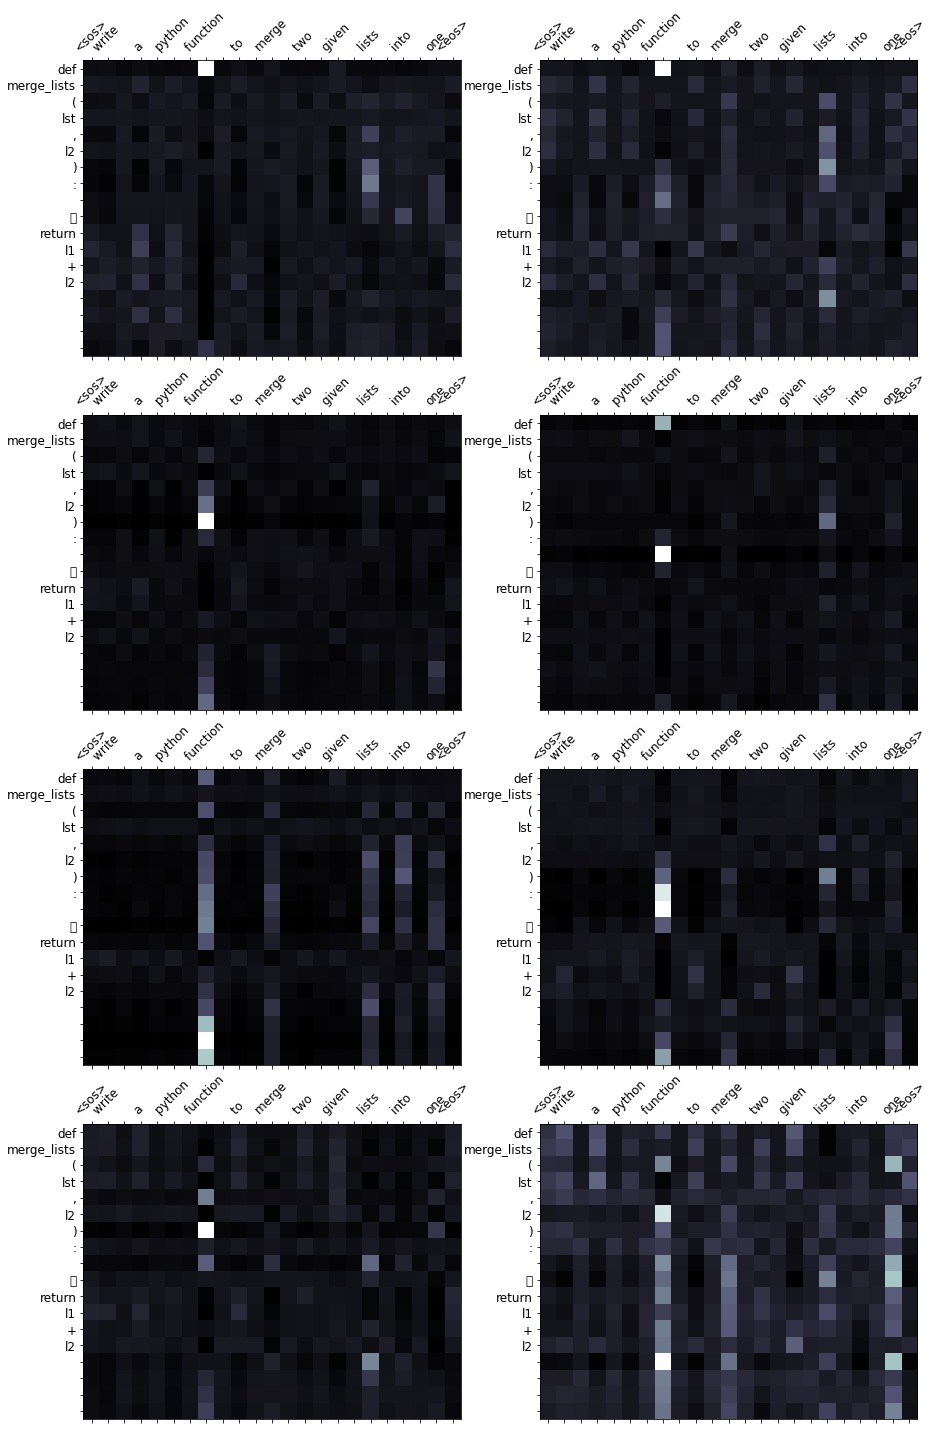

In [52]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.savefig('foo.png')
    plt.show()
user_queue = "write  a  python  function  to  merge  two  given  lists  into  one"

fields_1 = [('queue', queue),('snippet',snippet)]
temp = data.Example.fromlist([user_queue,""], fields_1)
translation, attention = translate_sentence(vars(temp)["queue"], queue, snippet, model, device)
display_attention(vars(temp)["queue"], translation[:-1], attention)

In [53]:
src,trg = vars(example[1])['queue'],vars(example[1])['snippet']

print("queue:")
print(" ".join(src))
print("*"*50)
print("\nsnippet:")
print(" ".join(trg))
print("*"*50)
translation, attention = translate_sentence(src, queue, snippet, model, device)
# print(f'predicted trg = {translation}')
print("\npredicted:")
print(" ".join(translation[:-1]))

queue:
write  a  python  function  to  add  two  user  provided  numbers  and  return  the  sum
**************************************************

snippet:
def add_two_numbers ( num1 , num2 ) : 
 	 sum = num1 + num2 
 return sum   
**************************************************

predicted:
def add_two_numbers ( num1 , num2 ) : 
 	 sum = num1 + num2 
 return sum   


In [54]:
for i in range(10):
  src,trg = vars(example[i])['queue'],vars(example[i])['snippet']
  print("#"*100)
  print("queue:")
  print(" ".join(src))
  print("*"*50)
  print("\nsnippet:\n")
  print(" ".join(trg))
  print("*"*50)
  translation, attention = translate_sentence(src, queue, snippet, model, device)
  # print(f'predicted trg = {translation}')
  print("\npredicted:")
  print(" ".join(translation[:-1]))
  print("#"*100)
  print("")

####################################################################################################
queue:
#  write  a  python  program  to  add  two  numbers 
**************************************************

snippet:

num1 = 1.5 
 num2 = 6.3 
 sum = num1 + num2 
 print ( f'Sum: {sum}' )  
**************************************************

predicted:
num1 = 1.5 
 num2 = 6.3 
 sum = num1 + num2 
 print ( f'Sum: {sum}' )  
####################################################################################################

####################################################################################################
queue:
write  a  python  function  to  add  two  user  provided  numbers  and  return  the  sum
**************************************************

snippet:

def add_two_numbers ( num1 , num2 ) : 
 	 sum = num1 + num2 
 return sum   
**************************************************

predicted:
def add_two_numbers ( num1 , num2 ) : 
 	 sum = num1 + num2 
 return s

In [55]:
sample_queue = ["merge two dictionaries"]
sample_snippet = [""]
fields = [('queue', queue),('snippet',snippet)]
sample_data = data.Example.fromlist([sample_queue[0],sample_snippet[0]], fields)
src = vars(sample_data)["queue"]
translation, attention = translate_sentence(src, queue, snippet, model, device)
print(f'predicted trg :\n{" ".join(translation[:-1])}')

predicted trg :
dict_1 = { 'apple' : 9 , 'banana' : 8 } 
 dict_2 = { 'banana' : 4 , 'orange' : 6 } 
 combined_dict = { ** dict_1 , ** dict_2 } # z = x | y    


In [56]:
sample_queue = ["combine two dictionaries"]
sample_snippet = [""]
fields = [('queue', queue),('snippet',snippet)]
sample_data = data.Example.fromlist([sample_queue[0],sample_snippet[0]], fields)
src = vars(sample_data)["queue"]
translation, attention = translate_sentence(src, queue, snippet, model, device)
print(f'predicted trg :\n{" ".join(translation[:-1])}')

predicted trg :
dict1 = { 'a' : 12 , 'for' : 25 , 'c' : 9 } 
 dict2 = { 'Geeks' : 100 , 'geek' : 200 , 'for' : 300 } 
 for key in dict2 : 
 	 if key in dict1 : 
 	 	 dict2 [ key ] += 1 
  else : 
 	 	 pass 
   res = dict2 + str ( dict1 ) 
 print ( dict1 + str ( res ) )  


In [57]:
sample_queue = ["add two numbers"]
sample_snippet = [""]
fields = [('queue', queue),('snippet',snippet)]
sample_data = data.Example.fromlist([sample_queue[0],sample_snippet[0]], fields)
src = vars(sample_data)["queue"]
translation, attention = translate_sentence(src, queue, snippet, model, device)
print(f'predicted trg :\n{" ".join(translation[:-1])}')

predicted trg :
num1 = 1.5 
 num2 = 6.3 
 sum = num1 + num2 
 print ( f'Sum: {sum}' )  


In [59]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 450):
    
    trgs = []
    pred_trgs = []
    # count = 0
    for datum in data:
        # print(count)
        src = vars(datum)['queue']
        trg = vars(datum)['snippet']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        trg = [i.replace(" ", "") for i in trg]
        pred_trg = [i.replace(" ", "") for i in pred_trg]
        pred_trgs.append(pred_trg)
        trgs.append([trg])

        # count = count+1
        # break

    # print("trg : ",trg)
    # print("pred_trg : ",pred_trg)
    # print("here")
    return bleu_score(pred_trgs, trgs)
    # return trgs,pred_trgs

In [46]:
bleu_score = calculate_bleu(valid_data, queue, snippet, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 14.55


In [60]:
bleu_score = calculate_bleu(valid_data, queue, snippet, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 46.50
